In [74]:
from __future__ import print_function    
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
import scipy.sparse as sp                 # import sparse matrix library
from scipy.sparse.linalg import spsolve
import scipy.sparse as sp
#py.rcParams.update({'font.size': 14})

# import the file where the differentiation matrix operators are defined
   

In [75]:
# Defining custom plotting functions a voir après
def my_contourf(x,y,F,ttl):
    py.contourf(x,y,F,41,cmap = 'inferno')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0

def Diff_mat_1D(Nx):
    
    # First derivative
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # A division by (2*dx) is required later.
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               # this is 2nd order forward difference (2*dx division is required)
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  # this is 2nd order backward difference (2*dx division is required)
    
    # Second derivative
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # division by dx^2 required
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    # this is 2nd order forward difference. division by dx^2 required. 
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  # this is 2nd order backward difference. division by dx^2 required.
    
    return D_1d, D2_1d


def Diff_mat_2D(Nx,Ny):
    # 1D differentiation matrices
    Dx_1d, D2x_1d = Diff_mat_1D(Nx)
    Dy_1d, D2y_1d = Diff_mat_1D(Ny)


    # Sparse identity matrices
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)


    
    # 2D matrix operators from 1D operators using kronecker product
    # First partial derivatives
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    
    # Second partial derivatives
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    
   
    
    # Return compressed Sparse Row format of the sparse matrices
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()

In [129]:
# Conditions de Dirichlet sur les bords du maillage
uL = 1
uR = 1
uT = 1
uB = 1

#Conditions de Dirichlet dans l'espace
eo = 8.85e-12
upos = 1/eo
uneg = -1/eo
 
xlimite = [0.25, 0.75]        # lower and upper limits of x defining the inner boundary region
yupos = 0.4  
yuneg = 0.6

# Maillage de l'espace
I = 50
J = 50                       
x = np.linspace(0,1,I)     
y = np.linspace(0,1,J)        

dx = x[1] - x[0]                #pas selon x
dy = y[1] - y[0]                #pas selon y

X,Y = np.meshgrid(x,y)       #création de la matrice de maillage   

# Réindexation 2D à 1D
Xlist = X.ravel()                  # Créer l'array des abscisses 1D
Ylist = Y.ravel()

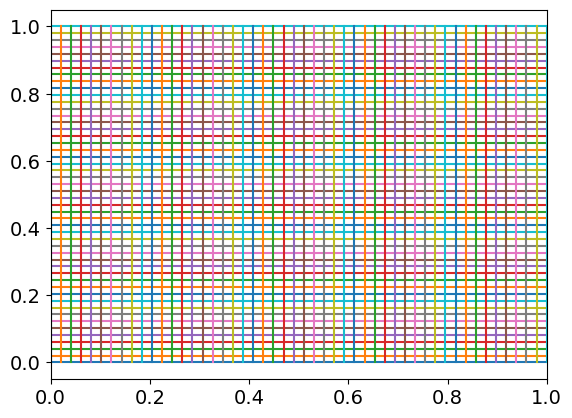

In [130]:
#Création du maillage sur x et y 
plt.plot(X)
plt.plot(X,Y)
xlim([0,1])
plt.show()

In [121]:
#Création de la matrice source
g = np.zeros(I*J) 

Xu

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444

In [131]:
# Indices des bords pour construire la boite avec les conditions de Dirichlet

ind_bord_gauche = np.squeeze(np.where(Xu==x[0]))          # renvoie l'indice des bords à gauche de la boite 
ind_bord_droit = np.squeeze(np.where(Xu==x[I-1]))       
ind_bord_bas = np.squeeze(np.where(Yu==y[0]))         
ind_bord_haut = np.squeeze(np.where(Yu==y[J-1]))  

# Indices des lignes de charges positives et négatives
#ligne positive
list_charge_pos = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yupos)))  # renvoie l'indice des lignes ou il y a les charges positives
list_charge_pos_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yupos))    # renvoie l'indice des lignes ou il y a les charges positives sur la vrai matrice
#ligne négative
list_charge_neg = np.squeeze(np.where((Xu>xlimite[0]) & (Xu<xlimite[1]) & (Yu==yuneg)))  # renvoie l'indice des lignes ou il y a les charges négatives
list_charge_pos_reel = np.where((X>xlimite[0]) & (X<xlimite[1]) & (Y==yuneg))    


print(ind_bord_bas, ind_bord_gauche)

# Indices du maillages
ind_bords_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[I-1]) | (Yu==y[0]) | (Yu==y[J-1])))  # tous les bords en indice listé 
ind_bords = np.where((X==x[0]) | (X==x[I-1]) | (Y==y[0]) | (Y==y[J-1]))    # tous les bords en indice réel

ind_bords

[0 1 2 3 4 5 6 7 8 9] [ 0 10 20 30 40 50 60 70 80 90]


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9,
        10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18,
        18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26,
        27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35,
        35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43,
        44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 49, 49, 49]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25

Text(0.5, 1.0, "Maillage de l'espace")

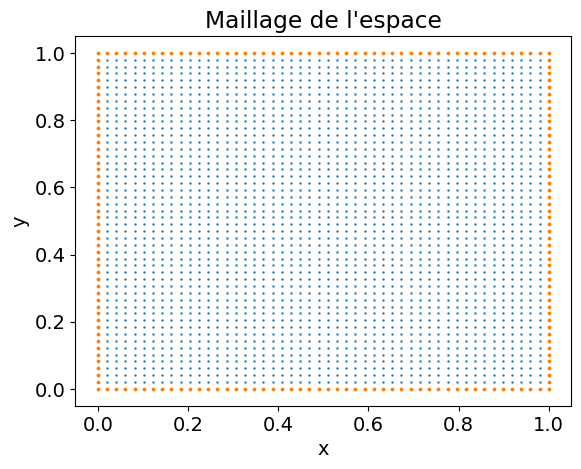

In [132]:
plt.scatter(X,Y,2,marker = '.') # création de l'espace maillé
plt.scatter(X[ind_bords],Y[ind_bords],3) # création des bords
plt.scatter(X[list_charge_pos_reel],Y[list_charge_pos_reel],5)
xlabel('x')
ylabel('y')
plt.title("Maillage de l'espace")

In [89]:
# Construction du vecteur source du système de Poisson
b = g
b[ind_bord_gauche] = uL # on rajoute les conditions sur les bords du maillage
b[ind_bord_droit] = uR
b[ind_bord_haut] = uT
b[ind_bord_bas] = uB

b[list_charge_pos] = upos # on rajoute les charges positives et négatives sur les lignes dans le vecteur b
b[list_charge_neg] = uneg

print(b)

NameError: name 'list_charge_pos' is not defined

0

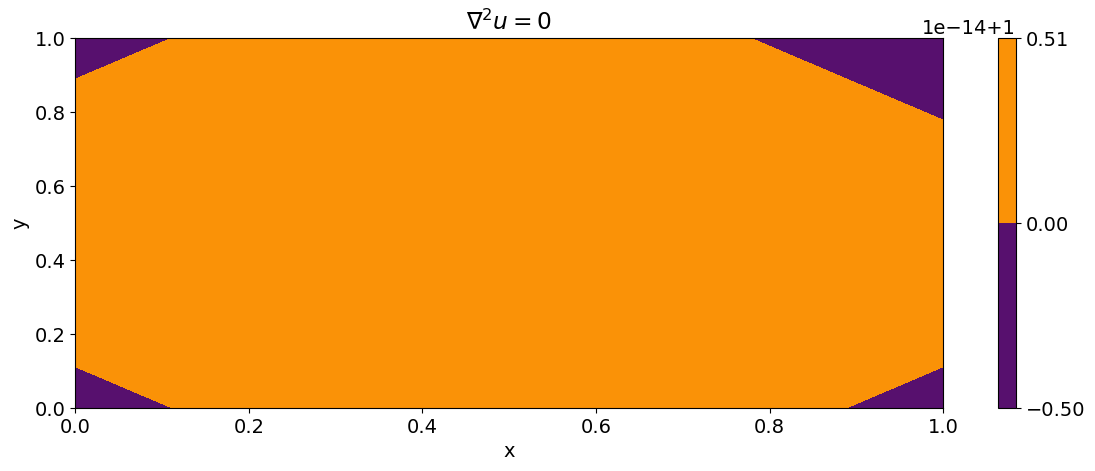

In [87]:
# Loading finite difference matrix operators

Dx_2d, Dy_2d, D2x_2d, D2y_2d = Diff_mat_2D(I,J)   # Calling 2D matrix operators from funciton




# Construction of the system matrix

I_sp = sp.eye(I*J).tocsr()
L_sys = D2x_2d/dx**2 + D2y_2d/dy**2     # system matrix without boundary conditions

L_sys[ind_bords_unravel,:] = I_sp[ind_bords_unravel,:]


# Résolution de l'équation de Poisson avec la méthode sparse
start = time.time()
u = spsolve(L_sys,b).reshape(I,J)


# Résolution de l'équation avec la méthode de Jacobi




# Résolution de l'équation avec la méthode Gauss-Seidel



# Résolution de l'équation avec la méthode de sur-relaxation


# Plot solution
py.figure(figsize = (14,4.8))
my_contourf(x,y,u,r'$\nabla^2 u = 0$')